# Brain Tumor Classification
Dataset - https://www.kaggle.com/datasets/shauryas555/brian-tumor-mri-dataset

## Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import shutil
import cv2
import matplotlib.image as mping
import seaborn as se
%matplotlib inline
plt.style.use("ggplot")

## STEP 1 - Data Preapration

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
cd /content/gdrive/MyDrive/BrainTumorDetector/

/content/gdrive/MyDrive/BrainTumorDetector


In [9]:
# Dataset
import zipfile

z = zipfile.ZipFile('dataset.zip')

z.extractall()

In [10]:
#changing the file and converting all into jpg format

folder = 'brain_tumor_dataset/yes/'
count = 1

for filename in os.listdir(folder):
    source = folder + filename
    destination = folder + "Y_" +str(count)+".jpg"
    os.rename(source, destination)
    count+=1
print("All files are renamed in the yes dir.")

All files are renamed in the yes dir.


In [11]:
folder = 'brain_tumor_dataset/no/'
count = 1

for filename in os.listdir(folder):
    source = folder + filename
    destination = folder + "N_" +str(count)+".jpg"
    os.rename(source, destination)
    count+=1
print("All files are renamed in the NO dir.")

All files are renamed in the NO dir.


## STEP 2 - Exploatory Data Analysis (EDA)

In [12]:
listyes = os.listdir("brain_tumor_dataset/yes/")
number_file_yes = len(listyes)
print(number_file_yes)

listno = os.listdir("brain_tumor_dataset/no/")
number_file_no = len(listno)
print(number_file_no)

155
98


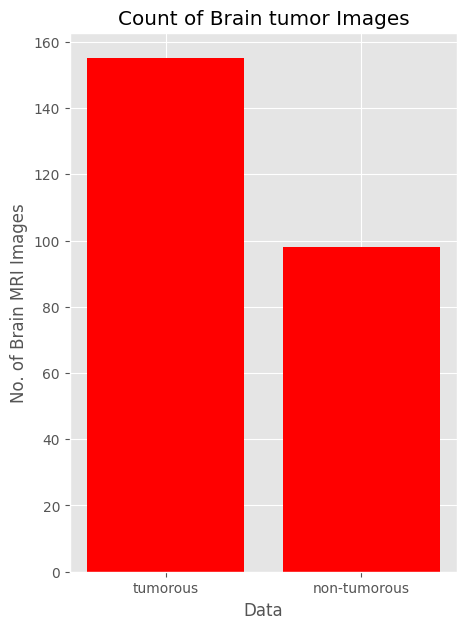

In [13]:
#plotting
data = {"tumorous": number_file_yes, "non-tumorous": number_file_no}

typex = data.keys()
values = data.values()

fig = plt.figure(figsize=(5,7))

plt.bar(typex, values, color="red")
plt.xlabel("Data")
plt.ylabel("No. of Brain MRI Images")
plt.title("Count of Brain tumor Images")
plt.show()
#we can see that our data is imbalanced

## STEP 3 - Data Augmentation

In [14]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

In [15]:
def timing(sec_elapsed):
    h = int(sec_elapsed / (60*60))
    m = int(sec_elapsed % (60*60) / 60)
    s = sec_elapsed % 60
    return f"{h}:{m}:{s}"

In [16]:
def augmented_data(file_dir, n_generated_samples, save_to_dir):
    data_gen = ImageDataGenerator(rotation_range=10,
                      width_shift_range=0.1,
                      height_shift_range=0.1,
                      shear_range=0.1,
                      brightness_range=(0.3, 1.0),
                      horizontal_flip=True,
                      vertical_flip=True,
                      fill_mode='nearest')
    for filename in os.listdir(file_dir):
        image = cv2.imread(file_dir + '/' + filename)
        image = image.reshape((1,) + image.shape)
        save_prefix = 'aug_' + filename[:-4]
        i=0
        for batch in data_gen.flow(x = image,
                                   batch_size = 1,
                                   save_to_dir = save_to_dir,
                                   save_prefix = save_prefix,
                                   save_format = "jpg"):
            i+=1
            if i>n_generated_samples:
                break

In [17]:
import os
import time

start_time = time.time()

# Define paths
yes_path = "brain_tumor_dataset/yes"
no_path = "brain_tumor_dataset/no"
augmented_data_path = 'augmented_data/'

# Create the directories for augmented data if they do not exist
os.makedirs(augmented_data_path + "yes", exist_ok=True)
os.makedirs(augmented_data_path + "no", exist_ok=True)

# Call the augmented data function
augmented_data(file_dir=yes_path, n_generated_samples=6, save_to_dir=augmented_data_path + "yes")
augmented_data(file_dir=no_path, n_generated_samples=9, save_to_dir=augmented_data_path + "no")

end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time:.2f} seconds")

Execution time: 115.54 seconds


In [18]:
#check again if  the data is balanced or not
def data_summary(main_path):
    yes_path = "augmented_data/yes/"
    no_path = "augmented_data/no/"

    n_pos = len(os.listdir(yes_path))
    n_neg = len(os.listdir(no_path))

    n = (n_pos + n_neg)

    pos_percentage = (n_pos * 100)/n
    neg_percentage = (n_neg * 100)/n

    print(f" Number of samples: {n}")
    print(f"{n_pos} Number of positive sample in percentage: {pos_percentage}%")
    print(f"{n_neg} Number of negative sample in percentage: {neg_percentage}%")


In [19]:
data_summary(augmented_data_path)

 Number of samples: 2064
1084 Number of positive sample in percentage: 52.51937984496124%
980 Number of negative sample in percentage: 47.48062015503876%


In [20]:
#check the number of positive and negative samples
listyes = os.listdir("augmented_data/yes/")
number_file_yes = len(listyes)
print(number_file_yes)

listno = os.listdir("augmented_data/no/")
number_file_no = len(listno)
print(number_file_no)

1084
980


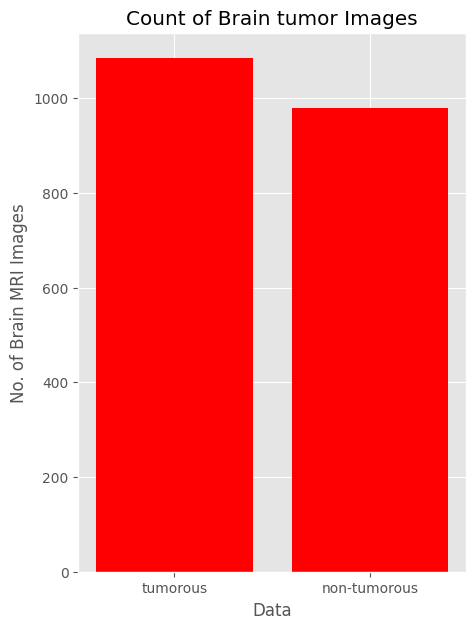

In [21]:
#plot the graph again
#plotting
data = {"tumorous": number_file_yes, "non-tumorous": number_file_no}

typex = data.keys()
values = data.values()

fig = plt.figure(figsize=(5,7))

plt.bar(typex, values, color="red")
plt.xlabel("Data")
plt.ylabel("No. of Brain MRI Images")
plt.title("Count of Brain tumor Images")
plt.show()

## STEP 4 -Data Preprocessing

In [22]:
import imutils
#it will remove the extra black pixcel from the image
def crop_brain_tumor(image, plot=False):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (5,5), 0)

    thres = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
    thres =cv2.erode(thres, None, iterations = 2)
    thres = cv2.dilate(thres, None, iterations = 2)

    cnts = cv2.findContours(thres.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    c = max(cnts, key = cv2.contourArea)

    extLeft = tuple(c[c[:,:,0].argmin()][0])
    extRight = tuple(c[c[:,:,0].argmax()][0])
    extTop = tuple(c[c[:,:,1].argmin()][0])
    extBot = tuple(c[c[:,:,1].argmax()][0])

    new_image = image[extTop[1]:extBot[1], extLeft[0]:extRight[0]]

    if plot:
        plt.figure()
        plt.subplot(1, 2, 1)
        plt.imshow(image)

        plt.tick_params(axis='both', which='both',
                        top=False, bottom=False, left=False, right=False,
                        labelbottom=False, labeltop=False, labelleft=False, labelright=False)

        plt.title('Original Image')

        plt.subplot(1, 2, 2)
        plt.imshow(new_image)

        plt.tick_params(axis='both', which='both',
                        top=False, bottom=False, left=False, right=False,
                        labelbottom=False, labeltop=False, labelleft=False, labelright=False)

        plt.title('Cropped Image')
        plt.show()
    return new_image

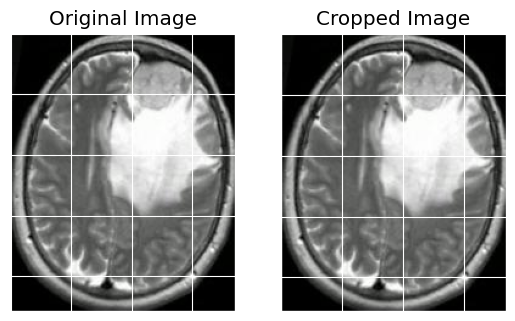

array([[[10, 11,  9],
        [10, 11,  9],
        [10, 11,  9],
        ...,
        [ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0]],

       [[ 9, 10,  8],
        [ 9, 10,  8],
        [ 9, 10,  8],
        ...,
        [ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0]],

       [[ 8,  9,  7],
        [ 8,  9,  7],
        [ 8,  9,  7],
        ...,
        [ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0]],

       ...,

       [[ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0],
        ...,
        [ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0]],

       [[ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0],
        ...,
        [ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0]],

       [[ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0],
        ...,
        [ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0]]], dtype=uint8)
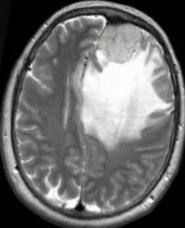

In [29]:
img = cv2.imread("augmented_data/yes/aug_Y_100_0_2677.jpg")
crop_brain_tumor(img, True)

In [30]:
folder1 = 'augmented_data/no/'
folder2 = 'augmented_data/yes/'

for filename in os.listdir(folder1):
    img = cv2.imread(folder1 + filename)
    img = crop_brain_tumor(img, False)
    cv2.imwrite(folder1 + filename, img)
for filename in os.listdir(folder2):
    img = cv2.imread(folder2 + filename)
    img = crop_brain_tumor(img, False)
    cv2.imwrite(folder2 + filename, img)

In [31]:
# image storing fucntion so that we can load the image function and try to plot some samples of the images
from sklearn.utils import shuffle
def load_data(dir_list, image_size):
    X=[] # all the features of teh vector
    y=[] # list of the classes (tumor or no tumor)

    image_width, image_height = image_size

    for directory in dir_list:
        for filename in os.listdir(directory):
            image = cv2.imread(directory + '/' + filename)
            image = crop_brain_tumor(image, plot=False)
            image = cv2.resize(image, dsize=(image_width, image_height), interpolation = cv2.INTER_CUBIC)# make all the images same size
            image = image/255.00
            X.append(image)
            if directory[-3:] == "yes":
                y.append(1)
            else:
                y.append(0)
    X=np.array(X)
    y=np.array(y)

    X,y = shuffle(X,y)
    print(f"Number of example is : {len(X)}")
    print(f"X SHAPE is : {X.shape}")
    print(f"y SHAPE is : {y.shape}")
    return X,y

In [32]:
augmented_path = 'augmented_data/'
augmeneted_yes = augmented_path + 'yes'
augmeneted_no = augmented_path + 'no'

IMAGE_WIDTH, IMAGE_HEIGHT = (240,240)

X,y = load_data([augmeneted_yes, augmeneted_no], (IMAGE_WIDTH, IMAGE_HEIGHT))

Number of example is : 2064
X SHAPE is : (2064, 240, 240, 3)
y SHAPE is : (2064,)


In [33]:
def plot_sample_images(X, y, n=50):

    for label in [0,1]:
        images = X[np.argwhere(y == label)]
        n_images = images[:n]

        columns_n = 10
        rows_n = int(n/ columns_n)

        plt.figure(figsize=(20, 10))

        i = 1
        for image in n_images:
            plt.subplot(rows_n, columns_n, i)
            plt.imshow(image[0])

            plt.tick_params(axis='both', which='both',
                            top=False, bottom=False, left=False, right=False,
                            labelbottom=False, labeltop=False, labelleft=False,
                            labelright=False)

            i += 1

        label_to_str = lambda label: "Yes" if label == 1 else "No"
        plt.suptitle(f"Brain Tumor: {label_to_str(label)}")
        plt.show()

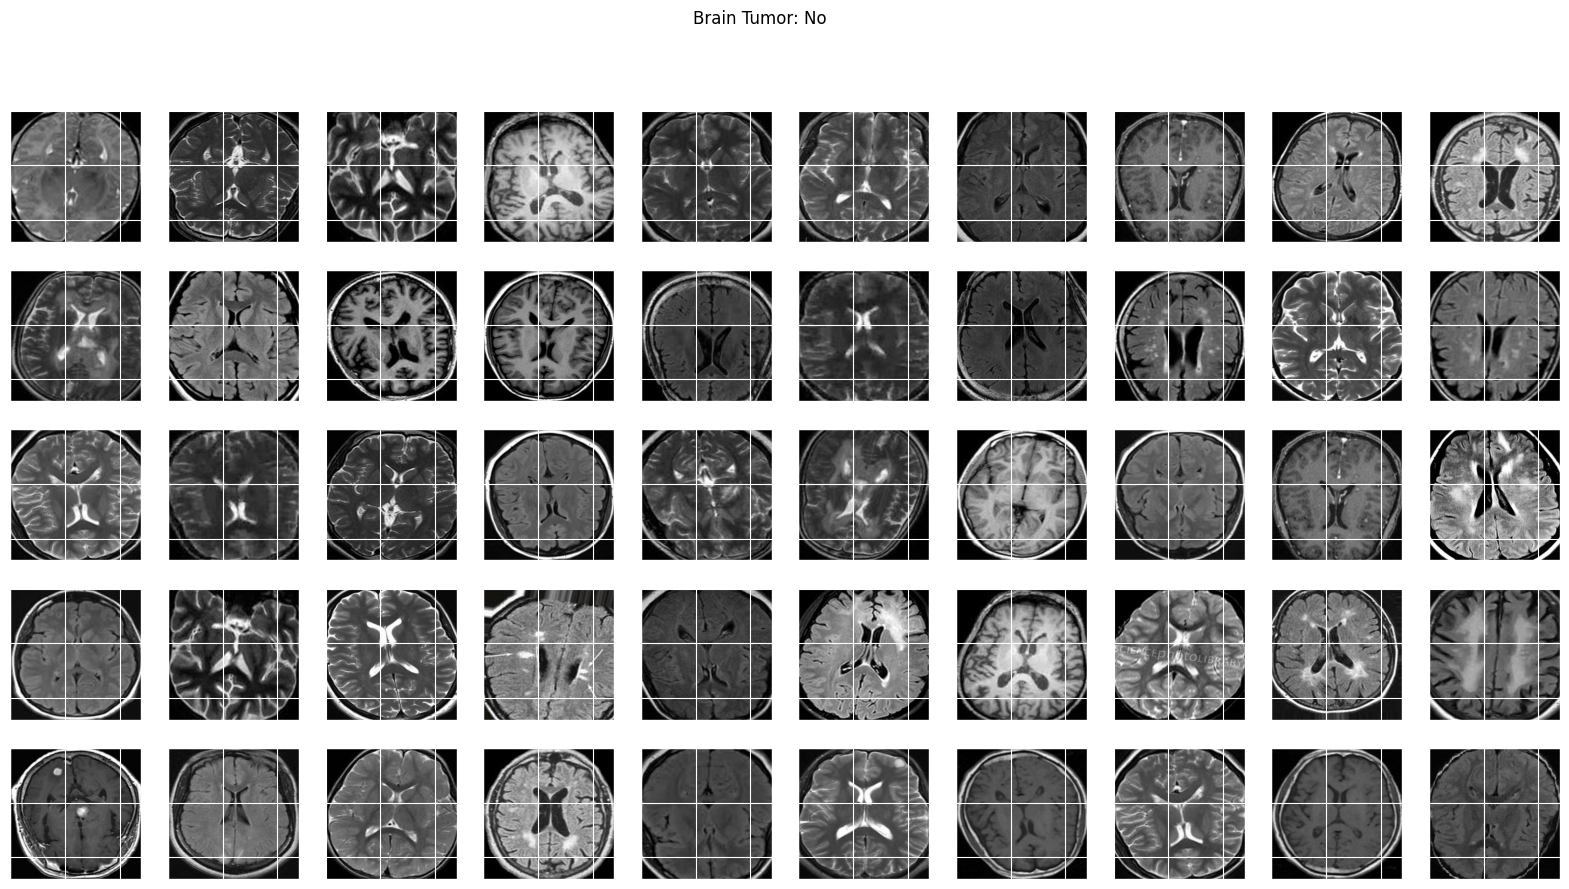

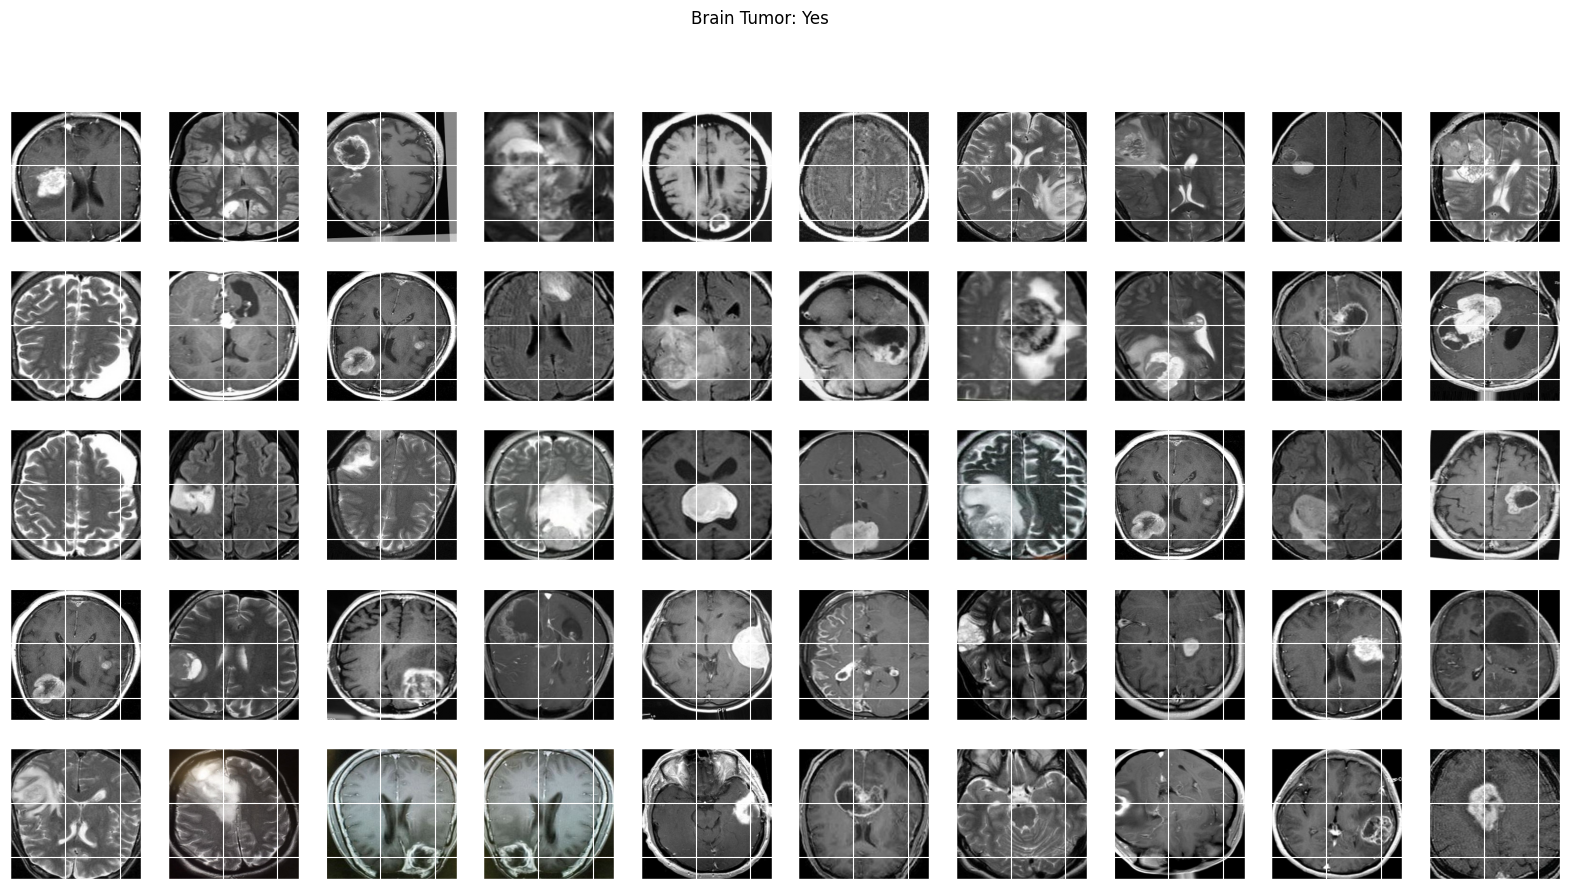

In [34]:
plot_sample_images(X,y)

## STEP 5 - Data Splitting

In [35]:
if not os.path.isdir('tumorous_and_nontumorous'):
    base_dir = 'tumorous_and_nontumorous'
    os.mkdir(base_dir)

In [36]:
if not os.path.isdir('tumorous_and_nontumorous/train'):
    train_dir = os.path.join(base_dir , 'train')
    os.mkdir(train_dir)

if not os.path.isdir('tumorous_and_nontumorous/test'):
    test_dir = os.path.join(base_dir , 'test')
    os.mkdir(test_dir)

if not os.path.isdir('tumorous_and_nontumorous/valid'):
    valid_dir = os.path.join(base_dir , 'valid')
    os.mkdir(valid_dir)

In [37]:
if not os.path.isdir("tumorous_and_nontumorous/train/tumorous"):
    infected_train_dir = os.path.join(train_dir, "tumorous")
    os.mkdir(infected_train_dir)

if not os.path.isdir("tumorous_and_nontumorous/test/tumorous"):
    infected_test_dir = os.path.join(test_dir, "tumorous")
    os.mkdir(infected_test_dir)

if not os.path.isdir("tumorous_and_nontumorous/valid/tumorous"):
    infected_valid_dir = os.path.join(valid_dir, "tumorous")
    os.mkdir(infected_valid_dir)


In [38]:
if not os.path.isdir("tumorous_and_nontumorous/train/nontumorous"):
    healthy_train_dir = os.path.join(train_dir, "nontumorous")
    os.mkdir(healthy_train_dir)

if not os.path.isdir("tumorous_and_nontumorous/test/nontumorous"):
    healthy_test_dir = os.path.join(test_dir, "nontumorous")
    os.mkdir(healthy_test_dir)

if not os.path.isdir("tumorous_and_nontumorous/valid/nontumorous"):
    healthy_valid_dir = os.path.join(valid_dir, "nontumorous")
    os.mkdir(healthy_valid_dir)


In [39]:
original_dataset_tumorours = os.path.join('augmented_data','yes/')
original_dataset_nontumorours = os.path.join('augmented_data','no/')

In [41]:
# 1084
# 980

#train test valid split for tumorous dataset

In [42]:
#for training dataset (80%)
files = os.listdir('augmented_data/yes/')
fnames = []
for i in range(0,868):
    fnames.append(files[i])
for fname in fnames:
    src = os.path.join(original_dataset_tumorours, fname)
    dst = os.path.join(infected_train_dir, fname)
    shutil.copyfile(src, dst)

In [43]:
#for testing dataset(10%)
files = os.listdir('augmented_data/yes/')
fnames = []
for i in range(868,977):
    fnames.append(files[i])
for fname in fnames:
    src = os.path.join(original_dataset_tumorours, fname)
    dst = os.path.join(infected_test_dir, fname)
    shutil.copyfile(src, dst)

In [44]:
#for valid dataset(10%)
files = os.listdir('augmented_data/yes/')
fnames = []
for i in range(977,1084):
    fnames.append(files[i])
for fname in fnames:
    src = os.path.join(original_dataset_tumorours, fname)
    dst = os.path.join(infected_valid_dir, fname)
    shutil.copyfile(src, dst)

In [45]:
#train test valid split for non-tumorous dataset

In [46]:
#for training dataset (80%)
files = os.listdir('augmented_data/no/')
fnames = []
for i in range(0,784):
    fnames.append(files[i])
for fname in fnames:
    src = os.path.join(original_dataset_nontumorours, fname)
    dst = os.path.join(healthy_train_dir, fname)
    shutil.copyfile(src, dst)

In [47]:
#for testing dataset(10%)
files = os.listdir('augmented_data/no/')
fnames = []
for i in range(784,882):
    fnames.append(files[i])
for fname in fnames:
    src = os.path.join(original_dataset_nontumorours, fname)
    dst = os.path.join(healthy_test_dir, fname)
    shutil.copyfile(src, dst)

In [48]:
#for valid dataset(10%)
files = os.listdir('augmented_data/no/')
fnames = []
for i in range(882,980):
    fnames.append(files[i])
for fname in fnames:
    src = os.path.join(original_dataset_nontumorours, fname)
    dst = os.path.join(healthy_valid_dir, fname)
    shutil.copyfile(src, dst)

## STEP 6 - Model Building

In [49]:
# Training data augmentation generator
train_datagen = ImageDataGenerator(
    rescale=1./255,               # Normalize pixel values to range [0, 1] from [0, 255].
    horizontal_flip=0.4,          # Randomly flip images horizontally with a 40% chance.
    vertical_flip=0.4,            # Randomly flip images vertically with a 40% chance.
    rotation_range=40,            # Randomly rotate images by up to 40 degrees.
    shear_range=0.2,              # Apply random shearing (slanting) transformation with a magnitude of 0.2.
    width_shift_range=0.4,        # Randomly shift the image horizontally by up to 40% of its width.
    height_shift_range=0.4,       # Randomly shift the image vertically by up to 40% of its height.
    fill_mode='nearest'           # Fill any empty space created by transformations with the nearest pixel values.
)

# Test data generator for rescaling only (no augmentation applied to test data)
test_data_gen = ImageDataGenerator(
    rescale=1.0/255               # Normalize pixel values to range [0, 1] from [0, 255] for testing.
)

# Validation data generator for rescaling only (no augmentation applied to validation data)
valid_data_gen = ImageDataGenerator(
    rescale=1.0/255               # Normalize pixel values to range [0, 1] from [0, 255] for validation.
)


In [50]:
train_generator = train_datagen.flow_from_directory('tumorous_and_nontumorous/train/', batch_size=32, target_size=(240,240), class_mode='categorical',shuffle=True, seed = 42, color_mode = 'rgb')

Found 1652 images belonging to 2 classes.


In [51]:
test_generator = train_datagen.flow_from_directory('tumorous_and_nontumorous/test/', batch_size=32, target_size=(240,240), class_mode='categorical',shuffle=True, seed = 42, color_mode = 'rgb')

Found 207 images belonging to 2 classes.


In [52]:
valid_generator = train_datagen.flow_from_directory('tumorous_and_nontumorous/valid/', batch_size=32, target_size=(240,240), class_mode='categorical',shuffle=True, seed = 42, color_mode = 'rgb')

Found 205 images belonging to 2 classes.


In [53]:
class_labels = train_generator.class_indices
class_name = {value: key for (key,value) in class_labels.items()}

In [54]:
class_name

{0: 'nontumorous', 1: 'tumorous'}

In [55]:
base_model = VGG19(input_shape = (240,240,3), include_top=False, weights='imagenet')

for layer in base_model.layers:
    layer.trainable=False

x=base_model.output
flat = Flatten()(x)

class_1 = Dense(4608, activation = 'relu')(flat)
drop_out = Dropout(0.2)(class_1)
class_2 = Dense(1152, activation = 'relu')(drop_out)
output = Dense(2, activation = 'softmax')(class_2)

model_01 = Model(base_model.input, output)
model_01.summary()

80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 240, 240, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 240, 240, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 240, 240, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 120, 120, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 120, 120, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 120, 120, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 60, 60, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 60, 60, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 60, 60, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 60, 60, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv4 (Conv2D)                │ (None, 60, 60, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 30, 30, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 30, 30, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 30, 30, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 30, 30, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv4 (Conv2D)                │ (None, 30, 30, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 15, 15, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 15, 15, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 15, 15, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 15, 15, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv4 (Conv2D)                │ (None, 15, 15, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 140,946,370 (537.67 MB)

 Trainable params: 120,921,986 (461.28 MB)

 Non-trainable params: 20,024,384 (76.39 MB)

In [56]:
# callback
filepath = 'model.keras'
es = EarlyStopping(monitor='val_loss', verbose = 1, mode='min',patience=4)
cp = ModelCheckpoint(filepath, monitor='val_loss', verbose = 1, save_best_only=True, save_weights_only=False, mode='auto',save_freq='epoch')
lrr = ReduceLROnPlateau(monitor='val_accuarcy', patience=3, verbose = 1, factor = 0.5, min_lr = 0.0001)

In [57]:
sgd = SGD(learning_rate=0.0001, decay = 1e-6, momentum = 0.9, nesterov = True)
model_01.compile(loss='categorical_crossentropy', optimizer = sgd, metrics=['accuracy'])

/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


In [63]:
history_01 = model_01.fit(train_generator, steps_per_epoch=75, epochs = 100, callbacks=[es,cp,lrr], validation_data=valid_generator)

Epoch 1/100
52/75 ━━━━━━━━━━━━━━━━━━━━ 12s 543ms/step - accuracy: 0.7440 - loss: 0.5098

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)



Epoch 1: val_loss did not improve from 0.62694
75/75 ━━━━━━━━━━━━━━━━━━━━ 37s 436ms/step - accuracy: 0.7434 - loss: 0.5089 - val_accuracy: 0.6098 - val_loss: 0.6322 - learning_rate: 1.0000e-04
Epoch 2/100


/usr/local/lib/python3.10/dist-packages/keras/src/callbacks/callback_list.py:96: UserWarning: Learning rate reduction is conditioned on metric `val_accuarcy` which is not available. Available metrics are: accuracy,loss,val_accuracy,val_loss,learning_rate.
  callback.on_epoch_end(epoch, logs)


52/75 ━━━━━━━━━━━━━━━━━━━━ 12s 550ms/step - accuracy: 0.7809 - loss: 0.4824
Epoch 2: val_loss did not improve from 0.62694
75/75 ━━━━━━━━━━━━━━━━━━━━ 40s 427ms/step - accuracy: 0.7757 - loss: 0.4856 - val_accuracy: 0.6000 - val_loss: 0.6403 - learning_rate: 1.0000e-04
Epoch 3/100
52/75 ━━━━━━━━━━━━━━━━━━━━ 13s 603ms/step - accuracy: 0.7642 - loss: 0.4921
Epoch 3: val_loss did not improve from 0.62694
75/75 ━━━━━━━━━━━━━━━━━━━━ 46s 501ms/step - accuracy: 0.7606 - loss: 0.4949 - val_accuracy: 0.5805 - val_loss: 0.7046 - learning_rate: 1.0000e-04
Epoch 4/100
52/75 ━━━━━━━━━━━━━━━━━━━━ 13s 581ms/step - accuracy: 0.7494 - loss: 0.5243
Epoch 4: val_loss did not improve from 0.62694
75/75 ━━━━━━━━━━━━━━━━━━━━ 37s 448ms/step - accuracy: 0.7507 - loss: 0.5204 - val_accuracy: 0.6341 - val_loss: 0.6521 - learning_rate: 1.0000e-04
Epoch 4: early stopping


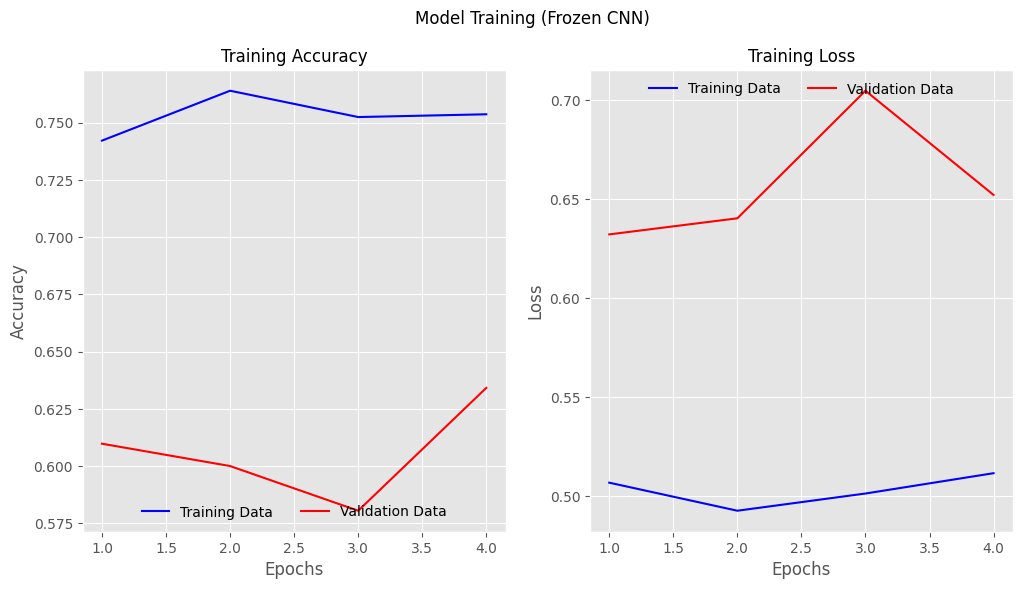

In [65]:
# Plot performance
fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12,6))
fig.suptitle("Model Training (Frozen CNN)", fontsize=12)
max_epoch = len(history_01.history['accuracy'])+1
epochs_list = list(range(1, max_epoch))

ax1.plot(epochs_list, history_01.history['accuracy'], color='b', linestyle='-', label='Training Data')
ax1.plot(epochs_list, history_01.history['val_accuracy'], color='r', linestyle='-', label='Validation Data')
ax1.set_title('Training Accuracy', fontsize=12)
ax1.set_xlabel('Epochs', fontsize=12)
ax1.set_ylabel('Accuracy', fontsize=12)
ax1.legend(frameon=False, loc='lower center', ncol=2)

ax2.plot(epochs_list, history_01.history['loss'], color='b', linestyle='-', label='Training Data')
ax2.plot(epochs_list, history_01.history['val_loss'], color='r', linestyle='-', label='Validation Data')
ax2.set_title('Training Loss', fontsize=12)
ax2.set_xlabel('Epochs', fontsize=12)
ax2.set_ylabel('Loss', fontsize=12)
ax2.legend(frameon=False, loc='upper center', ncol=2)
plt.savefig("training_frozencnn.jpeg", format='jpeg', dpi=100, bbox_inches='tight')

In [66]:
if not os.path.isdir('model_weights/'):
    os.mkdir('model_weights/')
model_01.save_weights(filepath="model_weights/vgg19_model_01.weights.h5", overwrite=True)

In [67]:
#check the performance of the model

model_01.load_weights("model_weights/vgg19_model_01.weights.h5")
vgg_val_eval_01 = model_01.evaluate(valid_generator)
vgg_test_eval_01 = model_01.evaluate(test_generator)

7/7 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 0.6411 - loss: 0.5914


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


7/7 ━━━━━━━━━━━━━━━━━━━━ 15s 2s/step - accuracy: 0.7418 - loss: 0.4649


In [68]:
print(f'Validation Loss: {vgg_val_eval_01[0]}')
print(f'Validation Acc: {vgg_val_eval_01[1]}')
print(f'Testing Loss: {vgg_test_eval_01[0]}')
print(f'Testing Acc: {vgg_test_eval_01[1]}')

Validation Loss: 0.6045350432395935
Validation Acc: 0.6439024209976196
Testing Loss: 0.46053558588027954
Testing Acc: 0.7584540843963623


In [69]:
filenames = test_generator.filenames
nb_sample = len(filenames)

vgg_prediction_01 = model_01.predict(test_generator, steps=nb_sample, verbose = 1)
y_pred = np.argmax(vgg_prediction_01, axis=1)

207/207 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step   


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


## STEP 7 - Increamental unfreezing and fine tuning

In [70]:
base_model = VGG19(include_top=False, input_shape=(240,240,3))
base_model_layer_names = [layer.name for layer in base_model.layers]
base_model_layer_names

['input_layer_1',
 'block1_conv1',
 'block1_conv2',
 'block1_pool',
 'block2_conv1',
 'block2_conv2',
 'block2_pool',
 'block3_conv1',
 'block3_conv2',
 'block3_conv3',
 'block3_conv4',
 'block3_pool',
 'block4_conv1',
 'block4_conv2',
 'block4_conv3',
 'block4_conv4',
 'block4_pool',
 'block5_conv1',
 'block5_conv2',
 'block5_conv3',
 'block5_conv4',
 'block5_pool']

In [71]:
base_model = VGG19(include_top=False, input_shape=(240,240,3))
base_model_layer_names = [layer.name for layer in base_model.layers]
base_model_layer_names

x=base_model.output
flat = Flatten()(x)

class_1 = Dense(4608, activation = 'relu')(flat)
drop_out = Dropout(0.2)(class_1)
class_2 = Dense(1152, activation = 'relu')(drop_out)
output = Dense(2, activation = 'softmax')(class_2)

model_02 = Model(base_model.inputs, output)
model_02.load_weights('model_weights/vgg19_model_01.weights.h5')

set_trainable=False
for layer in base_model.layers:
    if layer.name in ['block5_conv4','block5_conv3']:
        set_trainable=True
    if set_trainable:
        layer.trainable=True
    else:
        layer.trainable=False

print(model_02.summary())

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 240, 240, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 240, 240, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 240, 240, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 120, 120, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 120, 120, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 120, 120, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 60, 60, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 60, 60, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 60, 60, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 60, 60, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv4 (Conv2D)                │ (None, 60, 60, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 30, 30, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 30, 30, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 30, 30, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 30, 30, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv4 (Conv2D)                │ (None, 30, 30, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 15, 15, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 15, 15, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 15, 15, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 15, 15, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv4 (Conv2D)                │ (None, 15, 15, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 140,946,370 (537.67 MB)

 Trainable params: 125,641,602 (479.28 MB)

 Non-trainable params: 15,304,768 (58.38 MB)

None


In [72]:
sgd = SGD(learning_rate=0.0001, decay = 1e-6, momentum = 0.9, nesterov = True)
model_02.compile(loss='categorical_crossentropy', optimizer = sgd, metrics=['accuracy'])

/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


In [73]:
history_02 = model_02.fit(train_generator, steps_per_epoch=75, epochs = 50, callbacks=[es,cp,lrr], validation_data=valid_generator)

Epoch 1/50
52/75 ━━━━━━━━━━━━━━━━━━━━ 16s 730ms/step - accuracy: 0.7710 - loss: 0.4976
Epoch 1: val_loss did not improve from 0.62694
75/75 ━━━━━━━━━━━━━━━━━━━━ 56s 602ms/step - accuracy: 0.7692 - loss: 0.4991 - val_accuracy: 0.5659 - val_loss: 0.6790 - learning_rate: 1.0000e-04
Epoch 2/50


/usr/local/lib/python3.10/dist-packages/keras/src/callbacks/callback_list.py:96: UserWarning: Learning rate reduction is conditioned on metric `val_accuarcy` which is not available. Available metrics are: accuracy,loss,val_accuracy,val_loss,learning_rate.
  callback.on_epoch_end(epoch, logs)


52/75 ━━━━━━━━━━━━━━━━━━━━ 12s 561ms/step - accuracy: 0.7961 - loss: 0.4703
Epoch 2: val_loss improved from 0.62694 to 0.62522, saving model to model.keras
75/75 ━━━━━━━━━━━━━━━━━━━━ 110s 1s/step - accuracy: 0.7918 - loss: 0.4737 - val_accuracy: 0.6341 - val_loss: 0.6252 - learning_rate: 1.0000e-04
Epoch 3/50
52/75 ━━━━━━━━━━━━━━━━━━━━ 13s 567ms/step - accuracy: 0.7782 - loss: 0.4644
Epoch 3: val_loss improved from 0.62522 to 0.58515, saving model to model.keras
75/75 ━━━━━━━━━━━━━━━━━━━━ 84s 1s/step - accuracy: 0.7773 - loss: 0.4660 - val_accuracy: 0.6341 - val_loss: 0.5851 - learning_rate: 1.0000e-04
Epoch 4/50
52/75 ━━━━━━━━━━━━━━━━━━━━ 15s 691ms/step - accuracy: 0.7790 - loss: 0.4599
Epoch 4: val_loss did not improve from 0.58515
75/75 ━━━━━━━━━━━━━━━━━━━━ 101s 528ms/step - accuracy: 0.7809 - loss: 0.4579 - val_accuracy: 0.6341 - val_loss: 0.6081 - learning_rate: 1.0000e-04
Epoch 5/50
52/75 ━━━━━━━━━━━━━━━━━━━━ 12s 556ms/step - accuracy: 0.7956 - loss: 0.4432
Epoch 5: val_loss did 

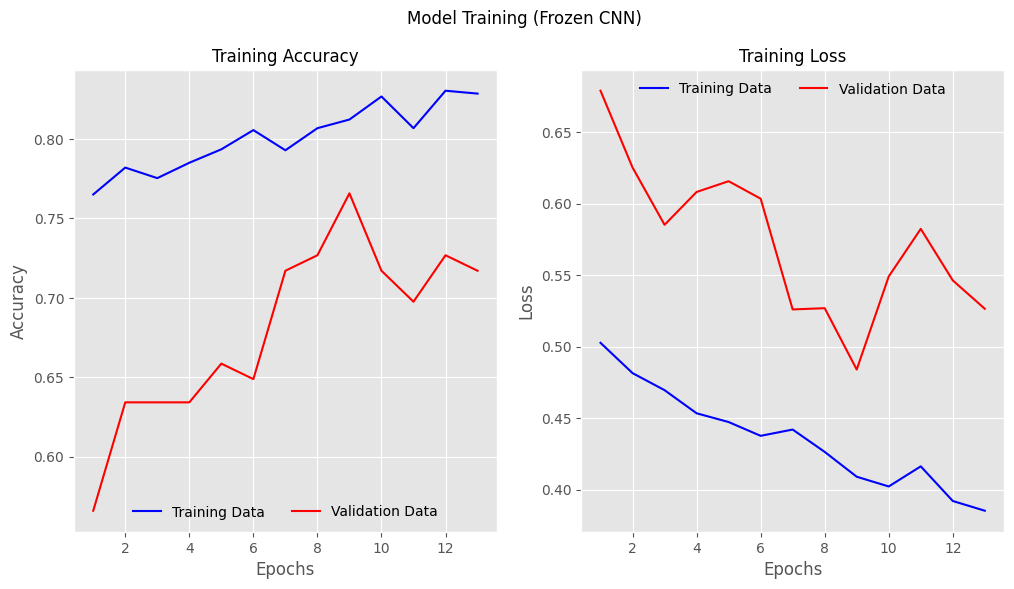

In [74]:
# Plot performance
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
fig.suptitle("Model Training (Frozen CNN)", fontsize=12)

# Get the number of epochs from the accuracy history
max_epoch = len(history_02.history['accuracy'])
epochs_list = list(range(1, max_epoch + 1))  # Ensure the correct range

# Training Accuracy Plot
ax1.plot(epochs_list, history_02.history['accuracy'], color='b', linestyle='-', label='Training Data')
ax1.plot(epochs_list, history_02.history['val_accuracy'], color='r', linestyle='-', label='Validation Data')
ax1.set_title('Training Accuracy', fontsize=12)
ax1.set_xlabel('Epochs', fontsize=12)
ax1.set_ylabel('Accuracy', fontsize=12)
ax1.legend(frameon=False, loc='lower center', ncol=2)

# Training Loss Plot
ax2.plot(epochs_list, history_02.history['loss'], color='b', linestyle='-', label='Training Data')
ax2.plot(epochs_list, history_02.history['val_loss'], color='r', linestyle='-', label='Validation Data')
ax2.set_title('Training Loss', fontsize=12)
ax2.set_xlabel('Epochs', fontsize=12)
ax2.set_ylabel('Loss', fontsize=12)
ax2.legend(frameon=False, loc='upper center', ncol=2)

# Save the figure
plt.savefig("training_frozencnn.jpeg", format='jpeg', dpi=100, bbox_inches='tight')
plt.show()

In [75]:
if not os.path.isdir('model_weights/'):
    os.mkdir('model_weights/')
model_02.save_weights(filepath="model_weights/vgg19_model_02.weights.h5", overwrite=True)

In [76]:
model_02.load_weights("model_weights/vgg19_model_02.weights.h5")
vgg_val_eval_02 = model_02.evaluate(valid_generator)
vgg_test_eval_02 = model_02.evaluate(test_generator)

7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 572ms/step - accuracy: 0.7248 - loss: 0.5299
7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 805ms/step - accuracy: 0.8429 - loss: 0.3584


### Unfreezing the entire network

In [77]:
base_model = VGG19(include_top=False, input_shape=(240,240,3))
base_model_layer_names = [layer.name for layer in base_model.layers]
base_model_layer_names

x=base_model.output
flat = Flatten()(x)

class_1 = Dense(4608, activation = 'relu')(flat)
drop_out = Dropout(0.2)(class_1)
class_2 = Dense(1152, activation = 'relu')(drop_out)
output = Dense(2, activation = 'softmax')(class_2)

model_03 = Model(base_model.inputs, output)
model_03.load_weights('model_weights/vgg19_model_02.weights.h5')

sgd = SGD(learning_rate=0.0001, decay = 1e-6, momentum = 0.9, nesterov = True)
model_03.compile(loss='categorical_crossentropy', optimizer = sgd, metrics=['accuracy'])

/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


In [78]:
model_03.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)           │ (None, 240, 240, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 240, 240, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 240, 240, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 120, 120, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 120, 120, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 120, 120, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 60, 60, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 60, 60, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 60, 60, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 60, 60, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv4 (Conv2D)                │ (None, 60, 60, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 30, 30, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 30, 30, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 30, 30, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 30, 30, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv4 (Conv2D)                │ (None, 30, 30, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 15, 15, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 15, 15, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 15, 15, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 15, 15, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv4 (Conv2D)                │ (None, 15, 15, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 140,946,370 (537.67 MB)

 Trainable params: 140,946,370 (537.67 MB)

 Non-trainable params: 0 (0.00 B)

In [79]:
history_03 = model_03.fit(train_generator, steps_per_epoch=50, epochs = 100, callbacks=[es,cp,lrr], validation_data=valid_generator)

Epoch 1/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8135 - loss: 0.4099
Epoch 1: val_loss improved from 0.48392 to 0.39821, saving model to model.keras
50/50 ━━━━━━━━━━━━━━━━━━━━ 177s 3s/step - accuracy: 0.8139 - loss: 0.4092 - val_accuracy: 0.8244 - val_loss: 0.3982 - learning_rate: 1.0000e-04
Epoch 2/100


/usr/local/lib/python3.10/dist-packages/keras/src/callbacks/callback_list.py:96: UserWarning: Learning rate reduction is conditioned on metric `val_accuarcy` which is not available. Available metrics are: accuracy,loss,val_accuracy,val_loss,learning_rate.
  callback.on_epoch_end(epoch, logs)


 2/50 ━━━━━━━━━━━━━━━━━━━━ 31s 664ms/step - accuracy: 0.8516 - loss: 0.4170

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)



Epoch 2: val_loss did not improve from 0.39821
50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 91ms/step - accuracy: 0.8291 - loss: 0.5052 - val_accuracy: 0.7463 - val_loss: 0.5388 - learning_rate: 1.0000e-04
Epoch 3/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 795ms/step - accuracy: 0.8518 - loss: 0.3321
Epoch 3: val_loss did not improve from 0.39821
50/50 ━━━━━━━━━━━━━━━━━━━━ 48s 878ms/step - accuracy: 0.8520 - loss: 0.3319 - val_accuracy: 0.8000 - val_loss: 0.4366 - learning_rate: 1.0000e-04
Epoch 4/100
 2/50 ━━━━━━━━━━━━━━━━━━━━ 34s 718ms/step - accuracy: 0.8203 - loss: 0.3953
Epoch 4: val_loss did not improve from 0.39821
50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 96ms/step - accuracy: 0.7978 - loss: 0.4423 - val_accuracy: 0.8098 - val_loss: 0.4347 - learning_rate: 1.0000e-04
Epoch 5/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 910ms/step - accuracy: 0.8962 - loss: 0.2685
Epoch 5: val_loss improved from 0.39821 to 0.37356, saving model to model.keras
50/50 ━━━━━━━━━━━━━━━━━━━━ 130s 2s/step - accuracy: 0.8962 - loss: 0.2684 - val_ac

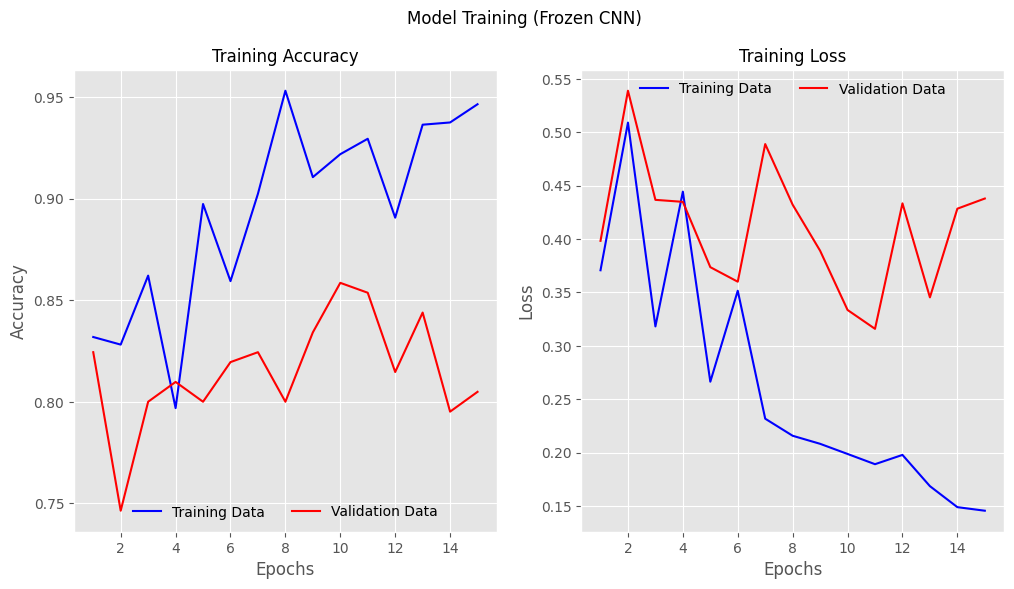

In [83]:
# Plot performance
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
fig.suptitle("Model Training (Frozen CNN)", fontsize=12)

# Get the number of epochs from the accuracy history
max_epoch = len(history_03.history['accuracy'])
epochs_list = list(range(1, max_epoch + 1))  # Ensure the correct range

# Training Accuracy Plot
ax1.plot(epochs_list, history_03.history['accuracy'], color='b', linestyle='-', label='Training Data')
ax1.plot(epochs_list, history_03.history['val_accuracy'], color='r', linestyle='-', label='Validation Data')
ax1.set_title('Training Accuracy', fontsize=12)
ax1.set_xlabel('Epochs', fontsize=12)
ax1.set_ylabel('Accuracy', fontsize=12)
ax1.legend(frameon=False, loc='lower center', ncol=2)

# Training Loss Plot
ax2.plot(epochs_list, history_03.history['loss'], color='b', linestyle='-', label='Training Data')
ax2.plot(epochs_list, history_03.history['val_loss'], color='r', linestyle='-', label='Validation Data')
ax2.set_title('Training Loss', fontsize=12)
ax2.set_xlabel('Epochs', fontsize=12)
ax2.set_ylabel('Loss', fontsize=12)
ax2.legend(frameon=False, loc='upper center', ncol=2)

# Save the figure
plt.savefig("training_frozencnn.jpeg", format='jpeg', dpi=100, bbox_inches='tight')
plt.show()

In [84]:
if not os.path.isdir('model_weights/'):
    os.mkdir('model_weights/')
model_02.save_weights(filepath="model_weights/vgg_unfrozen.weights.h5", overwrite=True)

In [85]:
model_02.load_weights("model_weights/vgg_unfrozen.weights.h5")
vgg_val_eval_02 = model_02.evaluate(valid_generator)
vgg_test_eval_02 = model_02.evaluate(test_generator)

7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 675ms/step - accuracy: 0.7441 - loss: 0.5167
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 490ms/step - accuracy: 0.8206 - loss: 0.3664
